# **Predicting Hate Crime Biases Using Multiclass Classification Machine Learning Models**

**Setup**

Import the necessary libraries.

In [ ]:
## for data manipulation
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for grouping sparse values
from statistics import median

## to normalize numerical features
from sklearn.preprocessing import MinMaxScaler

## for splitting the data
from sklearn.model_selection import train_test_split

## for evaluation metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, balanced_accuracy_score

## for neural network training
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import OneHotEncoder

import os
import shutil
import pickle as pk

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers

# **Data Collection, Analysis, and Preparation**

Read the hate crime data into a pandas dataframe.

In [ ]:
dtf = pd.read_csv('hate_crime.csv')
dtf = dtf.sort_values(by=['incident_id'])

Remove preliminary features and data points that will not be needed.

In [ ]:
# remove duplicate rows
dtf.drop_duplicates(inplace = True)

# remove columns that are duplicates or unnecessary
dtf = dtf.drop(columns=['incident_id', 'ori', 'pug_agency_name',
                        'pub_agency_unit', 'agency_type_name',
                        'state_abbr', 'population_group_code',
                        'incident_date', 'adult_victim_count',
                        'juvenile_victim_count', 'adult_offender_count',
                        'juvenile_offender_count'])

Categorical Variable to Dataframe Function

In [ ]:
# returns a dataframe of one hot vectors for all categories of a variable
def cat_to_dat(dtf, col, years, year_sensitive):
  # one hot vectors over years in years
 if year_sensitive:
   return (dtf[dtf.data_year.isin(years)])[col].astype(str).str.get_dummies(sep = ";")
  # one hot vectors over all years available
 else:
   return dtf[col].astype(str).str.get_dummies(sep = ";")

**Cleaning**

In [ ]:
# just take the first value if a row has multiple values for a single column
dtf['offense_name'] = dtf['offense_name'].str.split(';').str[0]
dtf['location_name'] = dtf['location_name'].str.split(';').str[0]
dtf['victim_types'] = dtf['victim_types'].str.split(';').str[0]

# only keep the 50 states plus D.C. plus federal
remove_states = ['Guam']
dtf = dtf[~dtf.state_name.isin(remove_states)]

dtf['state_name'] = dtf['state_name'].replace('Federal', 'Federal (State)')

# only keep the 9 U.S. divisions
# remove_divisions = ['Other', 'U.S. Territories']
# dtf = dtf[~dtf.division_name.isin(remove_divisions)]

dtf['division_name'] = dtf['division_name'].replace('Other', 'Federal (Division)')
dtf['division_name'] = dtf['division_name'].replace('U.S. Territories', 'U.S. Territories (Division)')

# only keep the 4 U.S. regions
# remove_regions = ['Other', 'U.S. Territories']
# dtf = dtf[~dtf.region_name.isin(remove_regions)]

dtf['region_name'] = dtf['region_name'].replace('Other', 'Federal (Region)')
dtf['region_name'] = dtf['region_name'].replace('U.S. Territories', 'U.S. Territories (Region)')

# remove State Police densities
# remove_densities = ['MSA State Police', 'Non-MSA State Police']
# dtf = dtf[~dtf.population_group_description.isin(remove_densities)]

# remove rows that have a null value for population densities
dtf = dtf[dtf.population_group_description.notnull()]

# keep relevant offenses
# keep_offenses = ['Aggravated Assault', 'Arson', 'Burglary/Breaking & Entering',
#                 'Destruction/Damage/Vandalism of Property', 'Intimidation',
#                 'Kidnapping/Abduction', 'Murder and Nonnegligent Manslaughter',
#                 'Rape', 'Robbery', 'Simple Assault', 'All Other Larceny',
#                 'Stolen Property Offenses', 'Theft From Building',
#                 'Theft From Motor Vehicle',
#                 'Theft of Motor Vehicle Parts or Accessories',
#                 'Motor Vehicle Theft']
# dtf = dtf[dtf.offense_name.isin(keep_offenses)]

# group larceny and theft offenses
# larceny_theft = ['All Other Larceny', 'Stolen Property Offenses',
#                 'Theft From Building', 'Theft From Motor Vehicle',
#                 'Theft of Motor Vehicle Parts or Accessories',
#                'Motor Vehicle Theft']
# for offense in larceny_theft:
#  dtf['offense_name'] = dtf['offense_name'].replace(offense, 'Larceny/Theft')

# remove sparse offenses
threshold = 0.0001 * dtf.shape[0]

offense_dtf = cat_to_dat(dtf, 'offense_name', years = [], year_sensitive = False)
offenses_to_remove = []

for col in offense_dtf.columns:
  if offense_dtf[col].sum() < threshold:
    offenses_to_remove.append(str(col))

dtf = dtf[~dtf.offense_name.isin(offenses_to_remove)]

# remove null total individual victim counts
dtf = dtf[dtf.total_individual_victims.notnull()]

# remove sparse locations
threshold = 0.0001 * dtf.shape[0]

location_dtf = cat_to_dat(dtf, 'location_name', years = [], year_sensitive = False)
locations_to_remove = []

for col in location_dtf.columns:
    if location_dtf[col].sum() < threshold:
      locations_to_remove.append(str(col))

dtf = dtf[~dtf.location_name.isin(locations_to_remove)]

dtf['offender_race'] = dtf['offender_race'].replace("Other/Unknown", 'Other/Unknown Location Type')

# remove unknown offender race
# remove_races = ['Unknown', 'Not Specified']
# dtf = dtf[~dtf.offender_race.isin(remove_races)]

dtf['offender_race'] = dtf['offender_race'].replace("Unknown", 'Unknown Race')
dtf['offender_race'] = dtf['offender_race'].replace("Not Specified", 'Unknown Race')
dtf['offender_race'] = dtf['offender_race'].replace("Multiple", 'Mixed Race')

# remove rows with unknown biases
dtf = dtf[dtf.bias_desc != "Unknown (offender's motivation not known)"]

# remove unknown victim types
#remove_victim_types = ['Unknown', 'Other']
# dtf = dtf[~dtf.victim_types.isin(remove_victim_types)]

dtf['victim_types'] = dtf['victim_types'].replace("Unknown", 'Unknown Victim Type')
dtf['victim_types'] = dtf['victim_types'].replace("Other", 'Other Victim Type')

# remove rows with multiple biases
dtf = dtf[dtf.multiple_bias != "M"]

# remove columns that are too empty or unnecessary
dtf = dtf.drop(columns=['offender_ethnicity', 'multiple_offense', 'multiple_bias'])

<ipython-input-5-ff63a0cb0135>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf['state_name'] = dtf['state_name'].replace('Federal', 'Federal (State)')
<ipython-input-5-ff63a0cb0135>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf['division_name'] = dtf['division_name'].replace('Other', 'Federal (Division)')
<ipython-input-5-ff63a0cb0135>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Create classification classes.

In [ ]:
# group biases for more general classification
anti_disability = ['Anti-Mental Disability', 'Anti-Physical Disability']

anti_gender = ['Anti-Female', 'Anti-Male']

anti_gender_identity = ['Anti-Gender Non-Conforming', 'Anti-Transgender']

anti_race_ethnicity_ancestry = ['Anti-American Indian or Alaska Native',
                                'Anti-Arab', 'Anti-Asian', 'Anti-Black or African American',
                                'Anti-Native Hawaiian or Other Pacific Islander',
                                'Anti-Hispanic or Latino', 'Anti-Multiple Races, Group',
                                'Anti-Other Race/Ethnicity/Ancestry', 'Anti-White']

anti_religion = ['Anti-Atheism/Agnosticism', 'Anti-Buddhist', 'Anti-Catholic',
                 'Anti-Eastern Orthodox (Russian, Greek, Other)', 'Anti-Hindu',
                 'Anti-Islamic (Muslim)', "Anti-Jehovah's Witness", 'Anti-Jewish',
                 'Anti-Mormon', 'Anti-Multiple Religions, Group', 'Anti-Other Christian',
                 'Anti-Other Religion', 'Anti-Protestant', 'Anti-Sikh', 'Anti-Church of Jesus Christ']

anti_sexual_orientation = ['Anti-Bisexual', 'Anti-Gay (Male)',
                  'Anti-Lesbian, Gay, Bisexual, or Transgender (Mixed Group)',
                  'Anti-Heterosexual', 'Anti-Lesbian (Female)']

bias_groups = [anti_disability, anti_gender, anti_gender_identity,
               anti_race_ethnicity_ancestry, anti_religion, anti_sexual_orientation]

bias_groups_str = ['Anti-Disability', 'Anti-Gender', 'Anti-Gender Identity',
                   'Anti-Race/Ethnicity/Ancestry', 'Anti-Religion',
                   'Anti-Sexual Orientation']

for index, bias_group in enumerate(bias_groups):
  for bias in bias_group:
    if index == 0:
          dtf['bias_desc'] = dtf['bias_desc'].replace(bias,'Anti-Disability')
    elif index == 1:
          dtf['bias_desc'] = dtf['bias_desc'].replace(bias,'Anti-Gender')
    elif index == 2:
          dtf['bias_desc'] = dtf['bias_desc'].replace(bias,'Anti-Gender Identity')
    elif index == 3:
          dtf['bias_desc'] = dtf['bias_desc'].replace(bias,'Anti-Race/Ethnicity/Ancestry')
    elif index == 4:
          dtf['bias_desc'] = dtf['bias_desc'].replace(bias,'Anti-Religion')
    elif index == 5:
          dtf['bias_desc'] = dtf['bias_desc'].replace(bias,'Anti-Sexual Orientation')

Missing Value Imputation

In [ ]:
# always at least 1 offender (impute to mode)
dtf.loc[dtf['total_offender_count'] == 0, 'total_offender_count'] = 1

In [ ]:
# re-index the rows
dtf = dtf.reset_index(drop = "True")

**Prepare data for training!**

Split the data into training and testing sets.

In [ ]:
y = dtf.bias_desc
X = dtf.drop(['bias_desc'], axis = 1)

In [ ]:
encoder = OneHotEncoder()

encoded_Y = encoder.fit(y.values.reshape(-1,1))
encoded_Y = encoded_Y.transform(y.values.reshape(-1,1)).toarray()

Split the data into training, validation, and testing sets.

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

trainX, testX, trainY, testY = train_test_split(X, encoded_Y, test_size= 1 - train_ratio,  random_state = 100, stratify = encoded_Y)
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio),  random_state = 100, stratify = testY)

Group Sparse Numerical Columns and Normalize Numerical Columns

In [ ]:
# Training Data

# replace numerical outliers with median
median_tiv_gt_10 = (trainX.loc[trainX['total_individual_victims'] > 10, 'total_individual_victims']).median()
trainX.loc[trainX['total_individual_victims'] > 10, 'total_individual_victims'] = median_tiv_gt_10

median_vc_gt_10 = (trainX.loc[trainX['victim_count'] > 10, 'victim_count']).median()
trainX.loc[trainX['victim_count'] > 10, 'victim_count'] = median_vc_gt_10

median_toc_gt_10 = (trainX.loc[trainX['total_offender_count'] > 10, 'total_offender_count']).median()
trainX.loc[trainX['total_offender_count'] > 10, 'total_offender_count'] = median_toc_gt_10

# normalize
mms1 = MinMaxScaler()
trainX[['total_individual_victims','victim_count', 'total_offender_count']] = mms1.fit_transform(trainX[['total_individual_victims','victim_count', 'total_offender_count']])

In [ ]:
# Validation Data

# replace numerical outliers with median
median_tiv_gt_10 = (valX.loc[valX['total_individual_victims'] > 10, 'total_individual_victims']).median()
valX.loc[valX['total_individual_victims'] > 10, 'total_individual_victims'] = median_tiv_gt_10

median_vc_gt_10 = (valX.loc[valX['victim_count'] > 10, 'victim_count']).median()
valX.loc[valX['victim_count'] > 10, 'victim_count'] = median_vc_gt_10

median_toc_gt_10 = (valX.loc[valX['total_offender_count'] > 10, 'total_offender_count']).median()
valX.loc[valX['total_offender_count'] > 10, 'total_offender_count'] = median_toc_gt_10

# normalize
mms2 = MinMaxScaler()
valX[['total_individual_victims','victim_count', 'total_offender_count']] = mms2.fit_transform(valX[['total_individual_victims','victim_count', 'total_offender_count']])

In [ ]:
#Testing Data

# replace numerical outliers with median
median_tiv_gt_10 = (testX.loc[testX['total_individual_victims'] > 10, 'total_individual_victims']).median()
testX.loc[testX['total_individual_victims'] > 10, 'total_individual_victims'] = median_tiv_gt_10

median_vc_gt_10 = (testX.loc[testX['victim_count'] > 10, 'victim_count']).median()
testX.loc[testX['victim_count'] > 10, 'victim_count'] = median_vc_gt_10

median_toc_gt_10 = (testX.loc[testX['total_offender_count'] > 10, 'total_offender_count']).median()
testX.loc[testX['total_offender_count'] > 10, 'total_offender_count'] = median_toc_gt_10

# normalize
mms3 = MinMaxScaler()
testX[['total_individual_victims','victim_count', 'total_offender_count']] = mms3.fit_transform(testX[['total_individual_victims','victim_count', 'total_offender_count']])

Create final dataframes for the training and testing sets.

In [ ]:
# create aggregate X dataframe with all categorical variables turned into one hot vectors
numerical_columns = ['total_offender_count', 'victim_count', 'total_individual_victims']

# trainX
new_dtf = pd.DataFrame()
for col in trainX.columns:
  if col not in numerical_columns:
    new_dtf = pd.concat([new_dtf, pd.get_dummies(trainX[col], drop_first = True)], axis = 1)
trainX = pd.concat([trainX[numerical_columns], new_dtf], axis = 1)

# valX
new_dtf = pd.DataFrame()
for col in valX.columns:
  if col not in numerical_columns:
    new_dtf = pd.concat([new_dtf, pd.get_dummies(valX[col], drop_first = True)], axis = 1)
valX = pd.concat([valX[numerical_columns], new_dtf], axis = 1)

# testX
new_dtf = pd.DataFrame()
for col in testX.columns:
  if col not in numerical_columns:
    new_dtf = pd.concat([new_dtf, pd.get_dummies(testX[col], drop_first = True)], axis = 1)
testX = pd.concat([testX[numerical_columns], new_dtf], axis = 1)

# make sure year columns are strings
trainX.columns = trainX.columns.astype(str)
valX.columns = valX.columns.astype(str)
testX.columns = testX.columns.astype(str)

In [ ]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(177060, 204)
(22133, 204)
(22133, 204)


Imbalanced Sampling

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 100, sampling_strategy = 'not majority')
trainX, trainY = smote.fit_resample(trainX, trainY)

In [ ]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(685806, 204)
(22133, 204)
(22133, 204)


# **Model Training and Evaluation**

Neural Network

Untuned Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 820       
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 6)                 30        
                                                                 
Total params: 870
Trainable params: 870
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
21423/21431 [============================>.] - ETA: 0s - loss: 1.0232 - categorical_accuracy: 0.5889

21431/21431 [==============================] - 44s 2ms/step - loss: 1.0232 - categorical_accuracy: 0.5889 - val_loss: 0.9806 - val_categorical_accuracy: 0.6005
Epoch 2/25
21407/21431 [============================>.] - ETA: 0s - loss: 0.9506 - categorical_accuracy: 0.6227

21431/21431 [==============================] - 44s 2ms/step - loss: 0.9505 - categorical_accuracy: 0.6227 - val_loss: 0.9539 - val_categorical_accuracy: 0.6241
Epoch 3/25
21431/21431 [==============================] - 43s 2ms/step - loss: 0.9412 - categorical_accuracy: 0.6257 - val_loss: 0.9850 - val_categorical_accuracy: 0.6075
Epoch 4/25
21431/21431 [==============================] - 44s 2ms/step - loss: 0.9380 - categorical_accuracy: 0.6276 - val_loss: 0.9898 - val_categorical_accuracy: 0.6022
Epoch 5/25
21431/21431 [==============================] - 45s 2ms/step - loss: 0.9359 - categorical_accuracy: 0.6290 - val_loss: 0.9768 - val_categorical_accuracy: 0.6108
Epoch 6/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.9343 - categorical_accuracy: 0.6300 - val_loss: 0.9672 - val_categorical_accuracy: 0.6140
Epoch 7/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.9326 - categorical_accuracy: 0.6317 - val_loss: 1.0035 - val_categorical_ac

21431/21431 [==============================] - 46s 2ms/step - loss: 0.9313 - categorical_accuracy: 0.6325 - val_loss: 0.9397 - val_categorical_accuracy: 0.6339
Epoch 9/25
21416/21431 [============================>.] - ETA: 0s - loss: 0.9303 - categorical_accuracy: 0.6325

21431/21431 [==============================] - 46s 2ms/step - loss: 0.9303 - categorical_accuracy: 0.6325 - val_loss: 0.9367 - val_categorical_accuracy: 0.6404
Epoch 10/25
21431/21431 [==============================] - 45s 2ms/step - loss: 0.9296 - categorical_accuracy: 0.6331 - val_loss: 0.9707 - val_categorical_accuracy: 0.6174
Epoch 11/25
21431/21431 [==============================] - 44s 2ms/step - loss: 0.9289 - categorical_accuracy: 0.6335 - val_loss: 1.0099 - val_categorical_accuracy: 0.5934
Epoch 12/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.9282 - categorical_accuracy: 0.6340 - val_loss: 0.9589 - val_categorical_accuracy: 0.6260
Epoch 13/25
21431/21431 [==============================] - 44s 2ms/step - loss: 0.9276 - categorical_accuracy: 0.6340 - val_loss: 0.9569 - val_categorical_accuracy: 0.6255
Epoch 14/25
21431/21431 [==============================] - 43s 2ms/step - loss: 0.9272 - categorical_accuracy: 0.6341 - val_loss: 0.9709 - val_categoric

691/691 [==============================] - 2s 2ms/step - loss: 0.9455 - categorical_accuracy: 0.6345


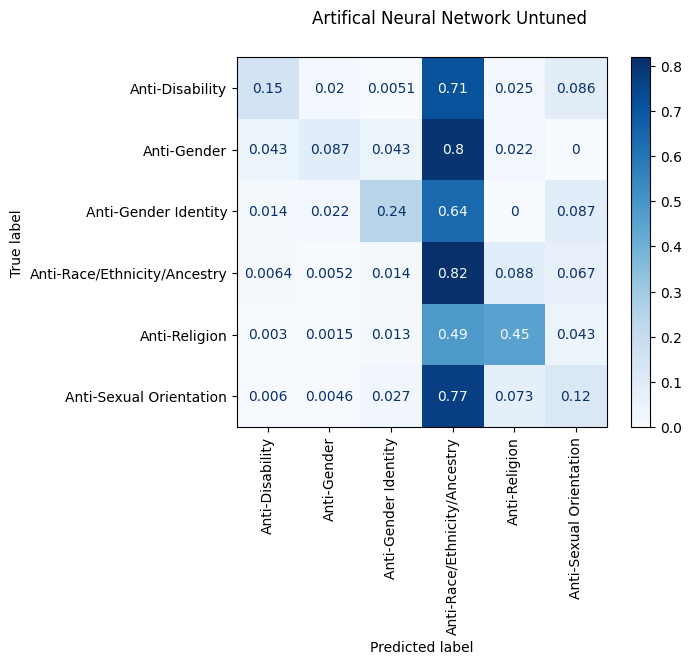

In [ ]:
checkpoint = 2023
sizes = [4]
rates = []

test_accuracies = []

for size in sizes:
  checkpoint_no = f"ckpt_{checkpoint}_ANN"
  model_name = f"HC_ANN_2FC_F{size}_{size}_epoch_25_no_dropout"
  checkpoint += 1

  input_shape = trainX.shape[1]

  n_batch_size = 32

  n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
  n_validation_steps = int(valX.shape[0] / n_batch_size)
  n_test_steps = int(testX.shape[0] / n_batch_size)

  n_epochs = 25

  num_classes = trainY.shape[1]

  model = models.Sequential()
  model.add(layers.Dense(size, activation='relu', input_shape=(input_shape,)))
  model.add(layers.Dense(size, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))

  model.summary()

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])

  # Prepare a directory to store all the checkpoints.
  checkpoint_dir = './'+ checkpoint_no
  if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

  keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name,
                                    monitor='val_loss', save_best_only=True, mode='auto')]

  history = model.fit(trainX,
                      trainY,
                      steps_per_epoch=n_steps_per_epoch,
                      epochs=n_epochs,
                      batch_size=n_batch_size,
                      validation_data=(valX, valY),
                      validation_steps=n_validation_steps,
                      callbacks=[keras_callbacks])

  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)

  testY_fixed = np.argmax(testY, axis=1)

  print(classification_report(testY_fixed, y_pred, digits = 4))

  disp = ConfusionMatrixDisplay.from_predictions(testY_fixed, y_pred, normalize = 'true',
  cmap=plt.cm.Blues, display_labels=bias_groups_str, xticks_rotation = 'vertical')
  fig = disp.figure_
  fig.suptitle('Artifical Neural Network Untuned')

  print('---------------------------------')

  hist_df = pd.DataFrame(history.history)
  hist_df['epoch'] = hist_df.index + 1
  cols = list(hist_df.columns)
  cols = [cols[-1]] + cols[:-1]
  hist_df = hist_df[cols]
  hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
  hist_df.head()

  values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
  values_of_best_model

  class_assignment = dict(zip(y, encoded_Y))

  df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
  df_temp = df_temp.stack()
  df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
  df_temp.columns = ['Category', 'Allocated Number']

  df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

  pk.dump(encoder, open(checkpoint_no + '/' + 'encoder.pkl', 'wb'))

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  #plt.plot(epochs, acc, 'r', label='Training Accuracy')
  #plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  #plt.title('Training and Validation Accuracy')
  #plt.legend()

  #plt.figure()

  #plt.plot(epochs, loss, 'r', label='Training Loss')
  #plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  #plt.title('Training and Validation Loss')
  #plt.legend()

  #plt.show()

  # Loading the automatically saved model
  model_reloaded = load_model(checkpoint_no + '/' + model_name)

  # Saving the best model in the correct path and format
  root_directory = os.getcwd()
  checkpoint_dir = os.path.join(root_directory, checkpoint_no)
  model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
  model_reloaded.save(model_name_temp)

  # Deletion of the automatically created folder under Model Checkpoint File.
  folder_name_temp = os.path.join(checkpoint_dir, model_name)
  shutil.rmtree(folder_name_temp, ignore_errors=True)

  best_model = load_model(model_name_temp)

  test_loss, test_acc = best_model.evaluate(testX,
                                            testY,
                                            steps=n_test_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                3280      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 3,654
Trainable params: 3,654
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
21416/21431 [============================

21431/21431 [==============================] - 50s 2ms/step - loss: 0.9740 - categorical_accuracy: 0.6155 - val_loss: 0.9416 - val_categorical_accuracy: 0.6328
Epoch 2/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.8856 - categorical_accuracy: 0.6557 - val_loss: 0.9475 - val_categorical_accuracy: 0.6293
Epoch 3/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.8688 - categorical_accuracy: 0.6618 - val_loss: 0.9538 - val_categorical_accuracy: 0.6282
Epoch 4/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.8607 - categorical_accuracy: 0.6641 - val_loss: 0.9515 - val_categorical_accuracy: 0.6342
Epoch 5/25
21430/21431 [============================>.] - ETA: 0s - loss: 0.8556 - categorical_accuracy: 0.6663

21431/21431 [==============================] - 49s 2ms/step - loss: 0.8556 - categorical_accuracy: 0.6663 - val_loss: 0.9361 - val_categorical_accuracy: 0.6415
Epoch 6/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.8516 - categorical_accuracy: 0.6676 - val_loss: 0.9617 - val_categorical_accuracy: 0.6213
Epoch 7/25
21425/21431 [============================>.] - ETA: 0s - loss: 0.8486 - categorical_accuracy: 0.6690

21431/21431 [==============================] - 49s 2ms/step - loss: 0.8486 - categorical_accuracy: 0.6690 - val_loss: 0.9301 - val_categorical_accuracy: 0.6378
Epoch 8/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.8473 - categorical_accuracy: 0.6696 - val_loss: 0.9368 - val_categorical_accuracy: 0.6404
Epoch 9/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.8454 - categorical_accuracy: 0.6700 - val_loss: 0.9636 - val_categorical_accuracy: 0.6279
Epoch 10/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.8438 - categorical_accuracy: 0.6707 - val_loss: 0.9311 - val_categorical_accuracy: 0.6383
Epoch 11/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.8433 - categorical_accuracy: 0.6709 - val_loss: 0.9544 - val_categorical_accuracy: 0.6241
Epoch 12/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.8414 - categorical_accuracy: 0.6713 - val_loss: 0.9610 - val_categorical

21431/21431 [==============================] - 47s 2ms/step - loss: 0.8398 - categorical_accuracy: 0.6723 - val_loss: 0.9251 - val_categorical_accuracy: 0.6477
Epoch 17/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.8398 - categorical_accuracy: 0.6726 - val_loss: 0.9502 - val_categorical_accuracy: 0.6359
Epoch 18/25
21431/21431 [==============================] - 45s 2ms/step - loss: 0.8398 - categorical_accuracy: 0.6728 - val_loss: 0.9510 - val_categorical_accuracy: 0.6331
Epoch 19/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.8385 - categorical_accuracy: 0.6736 - val_loss: 0.9672 - val_categorical_accuracy: 0.6221
Epoch 20/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.8389 - categorical_accuracy: 0.6734 - val_loss: 0.9515 - val_categorical_accuracy: 0.6330
Epoch 21/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.8374 - categorical_accuracy: 0.6734 - val_loss: 0.9534 - val_categoric

21431/21431 [==============================] - 46s 2ms/step - loss: 0.8376 - categorical_accuracy: 0.6735 - val_loss: 0.9223 - val_categorical_accuracy: 0.6466
Epoch 24/25
21431/21431 [==============================] - 44s 2ms/step - loss: 0.8375 - categorical_accuracy: 0.6739 - val_loss: 0.9807 - val_categorical_accuracy: 0.6170
Epoch 25/25
692/692 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0     0.2132    0.1472    0.1742       197
           1     0.0360    0.0870    0.0510        46
           2     0.0874    0.2754    0.1326       138
           3     0.7119    0.7979    0.7525     14288
           4     0.5679    0.4481    0.5009      3957
           5     0.3032    0.2002    0.2412      3507

    accuracy                         0.6301     22133
   macro avg     0.3200    0.3260    0.3087     22133
weighted avg     0.6117    0.6301    0.6160     22133

---------------------------------
644/691 [===============

691/691 [==============================] - 1s 2ms/step - loss: 0.9287 - categorical_accuracy: 0.6446
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                3280      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 6)                 102       
                                                                 
Total params: 3,654
Trainable params: 3,654
Non-trainable params: 0
_________________

21431/21431 [==============================] - 47s 2ms/step - loss: 1.2565 - categorical_accuracy: 0.4765 - val_loss: 1.0397 - val_categorical_accuracy: 0.5606
Epoch 2/25
21431/21431 [==============================] - 45s 2ms/step - loss: 1.1818 - categorical_accuracy: 0.5175 - val_loss: 1.0749 - val_categorical_accuracy: 0.5273
Epoch 3/25
21431/21431 [==============================] - 45s 2ms/step - loss: 1.1650 - categorical_accuracy: 0.5303 - val_loss: 1.0620 - val_categorical_accuracy: 0.5511
Epoch 4/25
21404/21431 [============================>.] - ETA: 0s - loss: 1.1579 - categorical_accuracy: 0.5336

21431/21431 [==============================] - 45s 2ms/step - loss: 1.1578 - categorical_accuracy: 0.5336 - val_loss: 1.0165 - val_categorical_accuracy: 0.5907
Epoch 5/25
21431/21431 [==============================] - 44s 2ms/step - loss: 1.1538 - categorical_accuracy: 0.5368 - val_loss: 1.0698 - val_categorical_accuracy: 0.5435
Epoch 6/25
21431/21431 [==============================] - 44s 2ms/step - loss: 1.1522 - categorical_accuracy: 0.5385 - val_loss: 1.0507 - val_categorical_accuracy: 0.5634
Epoch 7/25
21431/21431 [==============================] - 43s 2ms/step - loss: 1.1497 - categorical_accuracy: 0.5398 - val_loss: 1.0532 - val_categorical_accuracy: 0.5652
Epoch 8/25
21431/21431 [==============================] - 44s 2ms/step - loss: 1.1460 - categorical_accuracy: 0.5413 - val_loss: 1.0559 - val_categorical_accuracy: 0.5665
Epoch 9/25
21431/21431 [==============================] - 44s 2ms/step - loss: 1.1465 - categorical_accuracy: 0.5421 - val_loss: 1.0733 - val_categorical_ac

691/691 [==============================] - 1s 2ms/step - loss: 1.0289 - categorical_accuracy: 0.5848


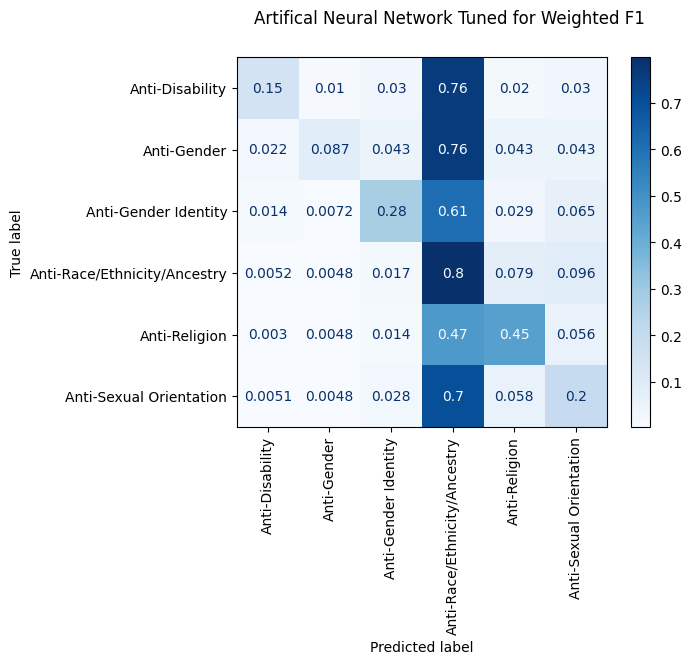

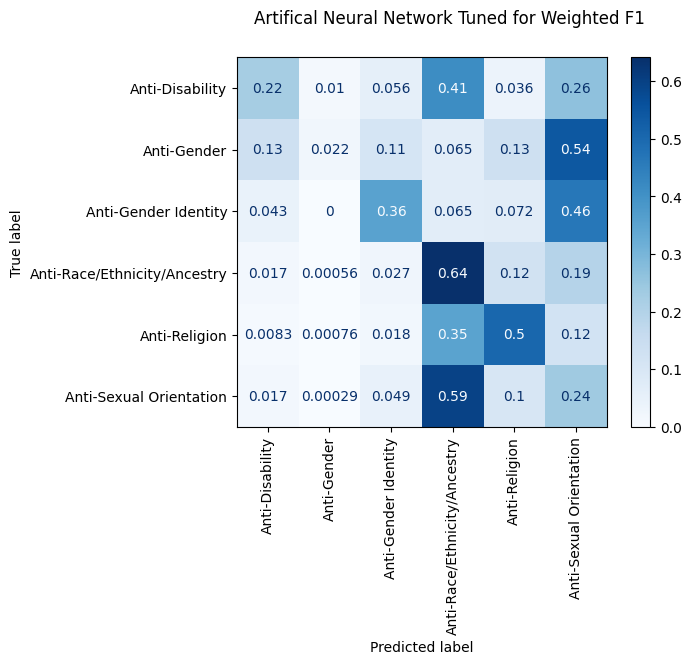

In [ ]:
sizes = [16]
rates = (x * 0.1 for x in [1, 5])

test_accuracies = []

for size in sizes:
  for rate in rates:
    checkpoint_no = f"ckpt_{checkpoint}_ANN"
    model_name = f"HC_ANN_2FC_F{size}_{size}_epoch_25_dropout_{rate}"
    checkpoint += 1

    input_shape = trainX.shape[1]

    n_batch_size = 32

    n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
    n_validation_steps = int(valX.shape[0] / n_batch_size)
    n_test_steps = int(testX.shape[0] / n_batch_size)

    n_epochs = 25

    num_classes = trainY.shape[1]

    model = models.Sequential()
    model.add(layers.Dense(size, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])

    # Prepare a directory to store all the checkpoints.
    checkpoint_dir = './'+ checkpoint_no
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name,
                                      monitor='val_loss', save_best_only=True, mode='auto')]

    history = model.fit(trainX,
                        trainY,
                        steps_per_epoch=n_steps_per_epoch,
                        epochs=n_epochs,
                        batch_size=n_batch_size,
                        validation_data=(valX, valY),
                        validation_steps=n_validation_steps,
                        callbacks=[keras_callbacks])

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    testY_fixed = np.argmax(testY, axis=1)

    print(classification_report(testY_fixed, y_pred, digits = 4))

    disp = ConfusionMatrixDisplay.from_predictions(testY_fixed, y_pred, normalize = 'true',
    cmap=plt.cm.Blues, display_labels=bias_groups_str, xticks_rotation = 'vertical')
    fig = disp.figure_
    fig.suptitle('Artifical Neural Network Tuned for Weighted F1')

    print('---------------------------------')

    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index + 1
    cols = list(hist_df.columns)
    cols = [cols[-1]] + cols[:-1]
    hist_df = hist_df[cols]
    hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
    hist_df.head()

    values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
    values_of_best_model

    class_assignment = dict(zip(y, encoded_Y))

    df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
    df_temp = df_temp.stack()
    df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
    df_temp.columns = ['Category', 'Allocated Number']

    df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

    pk.dump(encoder, open(checkpoint_no + '/' + 'encoder.pkl', 'wb'))

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    #plt.plot(epochs, acc, 'r', label='Training Accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    #plt.title('Training and Validation Accuracy')
    #plt.legend()

    #plt.figure()

    #plt.plot(epochs, loss, 'r', label='Training Loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()

    #plt.show()

    # Loading the automatically saved model
    model_reloaded = load_model(checkpoint_no + '/' + model_name)

    # Saving the best model in the correct path and format
    root_directory = os.getcwd()
    checkpoint_dir = os.path.join(root_directory, checkpoint_no)
    model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
    model_reloaded.save(model_name_temp)

    # Deletion of the automatically created folder under Model Checkpoint File.
    folder_name_temp = os.path.join(checkpoint_dir, model_name)
    shutil.rmtree(folder_name_temp, ignore_errors=True)

    best_model = load_model(model_name_temp)

    test_loss, test_acc = best_model.evaluate(testX,
                                              testY,
                                              steps=n_test_steps)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                6560      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
Total params: 7,814
Trainable params: 7,814
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
21430/21431 [============================

21431/21431 [==============================] - 48s 2ms/step - loss: 0.8732 - categorical_accuracy: 0.6565 - val_loss: 0.9729 - val_categorical_accuracy: 0.6006
Epoch 2/25
21425/21431 [============================>.] - ETA: 0s - loss: 0.7712 - categorical_accuracy: 0.7002

21431/21431 [==============================] - 47s 2ms/step - loss: 0.7713 - categorical_accuracy: 0.7002 - val_loss: 0.9333 - val_categorical_accuracy: 0.6354
Epoch 3/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.7479 - categorical_accuracy: 0.7089 - val_loss: 0.9378 - val_categorical_accuracy: 0.6440
Epoch 4/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.7358 - categorical_accuracy: 0.7141 - val_loss: 0.9442 - val_categorical_accuracy: 0.6354
Epoch 5/25
21412/21431 [============================>.] - ETA: 0s - loss: 0.7276 - categorical_accuracy: 0.7176

21431/21431 [==============================] - 50s 2ms/step - loss: 0.7276 - categorical_accuracy: 0.7176 - val_loss: 0.9169 - val_categorical_accuracy: 0.6517
Epoch 6/25
21431/21431 [==============================] - 51s 2ms/step - loss: 0.7216 - categorical_accuracy: 0.7197 - val_loss: 0.9437 - val_categorical_accuracy: 0.6402
Epoch 7/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.7175 - categorical_accuracy: 0.7212 - val_loss: 0.9322 - val_categorical_accuracy: 0.6429
Epoch 8/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.7124 - categorical_accuracy: 0.7235 - val_loss: 0.9242 - val_categorical_accuracy: 0.6448
Epoch 9/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.7099 - categorical_accuracy: 0.7242 - val_loss: 0.9349 - val_categorical_accuracy: 0.6443
Epoch 10/25
21407/21431 [============================>.] - ETA: 0s - loss: 0.7068 - categorical_accuracy: 0.7256

21431/21431 [==============================] - 49s 2ms/step - loss: 0.7068 - categorical_accuracy: 0.7256 - val_loss: 0.9155 - val_categorical_accuracy: 0.6509
Epoch 11/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.7063 - categorical_accuracy: 0.7261 - val_loss: 0.9547 - val_categorical_accuracy: 0.6319
Epoch 12/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.7044 - categorical_accuracy: 0.7275 - val_loss: 0.9193 - val_categorical_accuracy: 0.6493
Epoch 13/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.7030 - categorical_accuracy: 0.7278 - val_loss: 0.9486 - val_categorical_accuracy: 0.6340
Epoch 14/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.7022 - categorical_accuracy: 0.7277 - val_loss: 0.9369 - val_categorical_accuracy: 0.6323
Epoch 15/25
21420/21431 [============================>.] - ETA: 0s - loss: 0.7007 - categorical_accuracy: 0.7282

21431/21431 [==============================] - 47s 2ms/step - loss: 0.7008 - categorical_accuracy: 0.7282 - val_loss: 0.9106 - val_categorical_accuracy: 0.6510
Epoch 16/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.6997 - categorical_accuracy: 0.7285 - val_loss: 0.9251 - val_categorical_accuracy: 0.6453
Epoch 17/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.6977 - categorical_accuracy: 0.7299 - val_loss: 0.9392 - val_categorical_accuracy: 0.6399
Epoch 18/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.6976 - categorical_accuracy: 0.7303 - val_loss: 0.9275 - val_categorical_accuracy: 0.6458
Epoch 19/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.6965 - categorical_accuracy: 0.7298 - val_loss: 0.9272 - val_categorical_accuracy: 0.6462
Epoch 20/25
21431/21431 [==============================] - 46s 2ms/step - loss: 0.6966 - categorical_accuracy: 0.7300 - val_loss: 0.9400 - val_categoric

691/691 [==============================] - 1s 2ms/step - loss: 0.9138 - categorical_accuracy: 0.6494
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                6560      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 198       
                                                                 
Total params: 7,814
Trainable params: 7,814
Non-trainable params: 0
_________________

21431/21431 [==============================] - 53s 2ms/step - loss: 1.1072 - categorical_accuracy: 0.5586 - val_loss: 1.0212 - val_categorical_accuracy: 0.5481
Epoch 2/25
21428/21431 [============================>.] - ETA: 0s - loss: 1.0105 - categorical_accuracy: 0.6023

21431/21431 [==============================] - 50s 2ms/step - loss: 1.0105 - categorical_accuracy: 0.6023 - val_loss: 0.9800 - val_categorical_accuracy: 0.5962
Epoch 3/25
21426/21431 [============================>.] - ETA: 0s - loss: 0.9923 - categorical_accuracy: 0.6107

21431/21431 [==============================] - 50s 2ms/step - loss: 0.9923 - categorical_accuracy: 0.6107 - val_loss: 0.9734 - val_categorical_accuracy: 0.6166
Epoch 4/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.9848 - categorical_accuracy: 0.6145 - val_loss: 1.0051 - val_categorical_accuracy: 0.5993
Epoch 5/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.9785 - categorical_accuracy: 0.6178 - val_loss: 0.9771 - val_categorical_accuracy: 0.6344
Epoch 6/25
21427/21431 [============================>.] - ETA: 0s - loss: 0.9735 - categorical_accuracy: 0.6210

21431/21431 [==============================] - 49s 2ms/step - loss: 0.9735 - categorical_accuracy: 0.6211 - val_loss: 0.9700 - val_categorical_accuracy: 0.6421
Epoch 7/25
21430/21431 [============================>.] - ETA: 0s - loss: 0.9709 - categorical_accuracy: 0.6227

21431/21431 [==============================] - 50s 2ms/step - loss: 0.9709 - categorical_accuracy: 0.6228 - val_loss: 0.9663 - val_categorical_accuracy: 0.6388
Epoch 8/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.9681 - categorical_accuracy: 0.6228 - val_loss: 0.9958 - val_categorical_accuracy: 0.6266
Epoch 9/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.9665 - categorical_accuracy: 0.6238 - val_loss: 1.0145 - val_categorical_accuracy: 0.6181
Epoch 10/25
21431/21431 [==============================] - 47s 2ms/step - loss: 0.9646 - categorical_accuracy: 0.6251 - val_loss: 0.9918 - val_categorical_accuracy: 0.6282
Epoch 11/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.9641 - categorical_accuracy: 0.6251 - val_loss: 0.9787 - val_categorical_accuracy: 0.6442
Epoch 12/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.9622 - categorical_accuracy: 0.6263 - val_loss: 0.9777 - val_categorical

691/691 [==============================] - 1s 2ms/step - loss: 0.9746 - categorical_accuracy: 0.6396


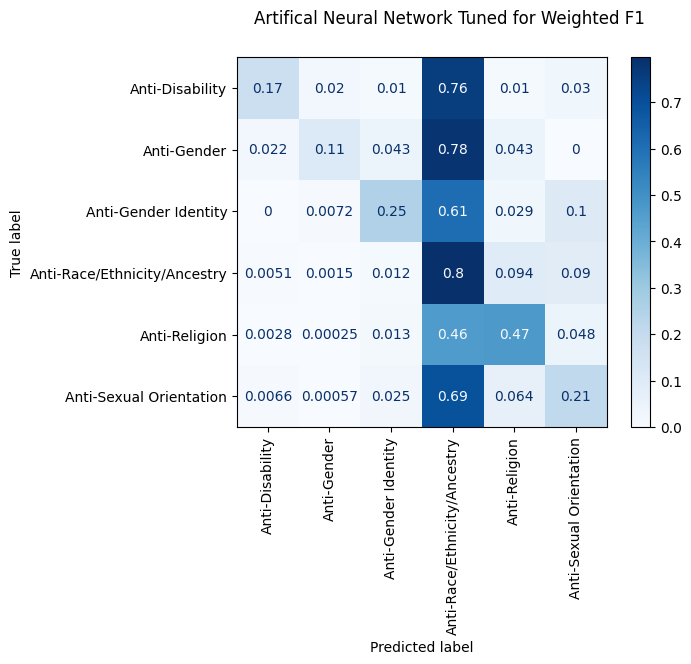

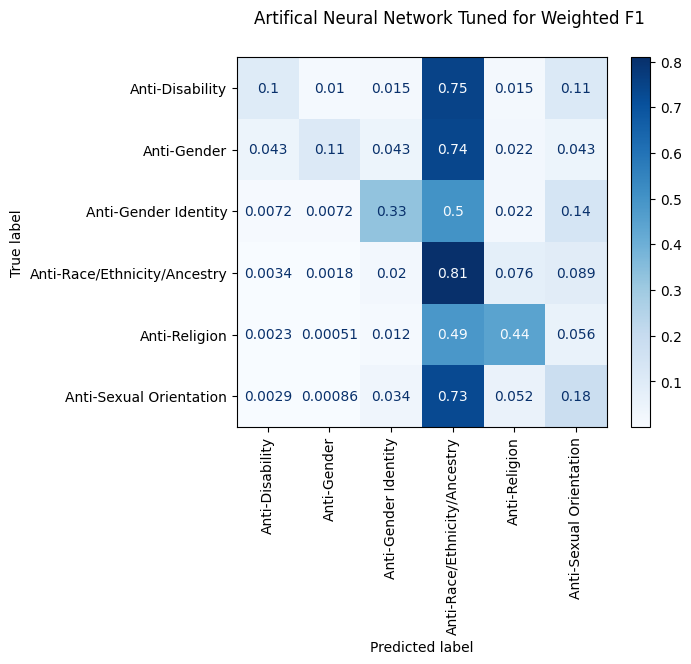

In [ ]:
sizes = [32]
rates = (x * 0.1 for x in [1, 5])

test_accuracies = []

for size in sizes:
  for rate in rates:
    checkpoint_no = f"ckpt_{checkpoint}_ANN"
    model_name = f"HC_ANN_2FC_F{size}_{size}_epoch_25_dropout_{rate}"
    checkpoint += 1

    input_shape = trainX.shape[1]

    n_batch_size = 32

    n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
    n_validation_steps = int(valX.shape[0] / n_batch_size)
    n_test_steps = int(testX.shape[0] / n_batch_size)

    n_epochs = 25

    num_classes = trainY.shape[1]

    model = models.Sequential()
    model.add(layers.Dense(size, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])

    # Prepare a directory to store all the checkpoints.
    checkpoint_dir = './'+ checkpoint_no
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name,
                                      monitor='val_loss', save_best_only=True, mode='auto')]

    history = model.fit(trainX,
                        trainY,
                        steps_per_epoch=n_steps_per_epoch,
                        epochs=n_epochs,
                        batch_size=n_batch_size,
                        validation_data=(valX, valY),
                        validation_steps=n_validation_steps,
                        callbacks=[keras_callbacks])

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    testY_fixed = np.argmax(testY, axis=1)

    print(classification_report(testY_fixed, y_pred, digits = 4))

    disp = ConfusionMatrixDisplay.from_predictions(testY_fixed, y_pred, normalize = 'true',
    cmap=plt.cm.Blues, display_labels=bias_groups_str, xticks_rotation = 'vertical')
    fig = disp.figure_
    fig.suptitle('Artifical Neural Network Tuned for Weighted F1')

    print('---------------------------------')

    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index + 1
    cols = list(hist_df.columns)
    cols = [cols[-1]] + cols[:-1]
    hist_df = hist_df[cols]
    hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
    hist_df.head()

    values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
    values_of_best_model

    class_assignment = dict(zip(y, encoded_Y))

    df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
    df_temp = df_temp.stack()
    df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
    df_temp.columns = ['Category', 'Allocated Number']

    df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

    pk.dump(encoder, open(checkpoint_no + '/' + 'encoder.pkl', 'wb'))

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    #plt.plot(epochs, acc, 'r', label='Training Accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    #plt.title('Training and Validation Accuracy')
    #plt.legend()

    #plt.figure()

    #plt.plot(epochs, loss, 'r', label='Training Loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()

    #plt.show()

    # Loading the automatically saved model
    model_reloaded = load_model(checkpoint_no + '/' + model_name)

    # Saving the best model in the correct path and format
    root_directory = os.getcwd()
    checkpoint_dir = os.path.join(root_directory, checkpoint_no)
    model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
    model_reloaded.save(model_name_temp)

    # Deletion of the automatically created folder under Model Checkpoint File.
    folder_name_temp = os.path.join(checkpoint_dir, model_name)
    shutil.rmtree(folder_name_temp, ignore_errors=True)

    best_model = load_model(model_name_temp)

    test_loss, test_acc = best_model.evaluate(testX,
                                              testY,
                                              steps=n_test_steps)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                13120     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 6)                 390       
                                                                 
Total params: 17,670
Trainable params: 17,670
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
21412/21431 [==========================

21431/21431 [==============================] - 52s 2ms/step - loss: 0.7969 - categorical_accuracy: 0.6879 - val_loss: 0.9385 - val_categorical_accuracy: 0.6269
Epoch 2/25
21422/21431 [============================>.] - ETA: 0s - loss: 0.6887 - categorical_accuracy: 0.7313

21431/21431 [==============================] - 51s 2ms/step - loss: 0.6887 - categorical_accuracy: 0.7313 - val_loss: 0.9214 - val_categorical_accuracy: 0.6486
Epoch 3/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.6607 - categorical_accuracy: 0.7422 - val_loss: 0.9486 - val_categorical_accuracy: 0.6236
Epoch 4/25
21415/21431 [============================>.] - ETA: 0s - loss: 0.6451 - categorical_accuracy: 0.7475

21431/21431 [==============================] - 51s 2ms/step - loss: 0.6451 - categorical_accuracy: 0.7475 - val_loss: 0.9112 - val_categorical_accuracy: 0.6523
Epoch 5/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.6355 - categorical_accuracy: 0.7513 - val_loss: 0.9301 - val_categorical_accuracy: 0.6402
Epoch 6/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.6275 - categorical_accuracy: 0.7548 - val_loss: 0.9127 - val_categorical_accuracy: 0.6526
Epoch 7/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.6226 - categorical_accuracy: 0.7570 - val_loss: 0.9123 - val_categorical_accuracy: 0.6496
Epoch 8/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.6174 - categorical_accuracy: 0.7589 - val_loss: 0.9298 - val_categorical_accuracy: 0.6427
Epoch 9/25
21431/21431 [==============================] - 51s 2ms/step - loss: 0.6153 - categorical_accuracy: 0.7593 - val_loss: 0.9330 - val_categorical_ac

21431/21431 [==============================] - 51s 2ms/step - loss: 0.6075 - categorical_accuracy: 0.7625 - val_loss: 0.9061 - val_categorical_accuracy: 0.6518
Epoch 13/25
21431/21431 [==============================] - 51s 2ms/step - loss: 0.6054 - categorical_accuracy: 0.7635 - val_loss: 0.9319 - val_categorical_accuracy: 0.6376
Epoch 14/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.6037 - categorical_accuracy: 0.7642 - val_loss: 0.9231 - val_categorical_accuracy: 0.6462
Epoch 15/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.6019 - categorical_accuracy: 0.7648 - val_loss: 0.9213 - val_categorical_accuracy: 0.6496
Epoch 16/25
21431/21431 [==============================] - 51s 2ms/step - loss: 0.6005 - categorical_accuracy: 0.7653 - val_loss: 0.9199 - val_categorical_accuracy: 0.6487
Epoch 17/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.5993 - categorical_accuracy: 0.7658 - val_loss: 0.9299 - val_categoric

21431/21431 [==============================] - 50s 2ms/step - loss: 0.5940 - categorical_accuracy: 0.7678 - val_loss: 0.9042 - val_categorical_accuracy: 0.6555
Epoch 24/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.5934 - categorical_accuracy: 0.7687 - val_loss: 0.9367 - val_categorical_accuracy: 0.6421
Epoch 25/25
692/692 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0     0.3167    0.1929    0.2397       197
           1     0.1429    0.0870    0.1081        46
           2     0.1172    0.2464    0.1589       138
           3     0.7151    0.8139    0.7613     14288
           4     0.5716    0.4508    0.5041      3957
           5     0.3436    0.2264    0.2729      3507

    accuracy                         0.6453     22133
   macro avg     0.3678    0.3362    0.3408     22133
weighted avg     0.6221    0.6453    0.6282     22133

---------------------------------
650/691 [===============

691/691 [==============================] - 1s 2ms/step - loss: 0.9025 - categorical_accuracy: 0.6561
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                13120     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 6)                 390       
                                                                 
Total params: 17,670
Trainable params: 17,670
Non-trainable params: 0
_______________

21431/21431 [==============================] - 54s 2ms/step - loss: 0.9913 - categorical_accuracy: 0.6122 - val_loss: 0.9270 - val_categorical_accuracy: 0.6419
Epoch 2/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.8839 - categorical_accuracy: 0.6607 - val_loss: 0.9370 - val_categorical_accuracy: 0.6492
Epoch 3/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.8615 - categorical_accuracy: 0.6691 - val_loss: 0.9420 - val_categorical_accuracy: 0.6485
Epoch 4/25
21431/21431 [==============================] - 48s 2ms/step - loss: 0.8496 - categorical_accuracy: 0.6739 - val_loss: 0.9428 - val_categorical_accuracy: 0.6490
Epoch 5/25
21431/21431 [==============================] - 49s 2ms/step - loss: 0.8416 - categorical_accuracy: 0.6769 - val_loss: 0.9609 - val_categorical_accuracy: 0.6433
Epoch 6/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.8359 - categorical_accuracy: 0.6795 - val_loss: 0.9700 - val_categorical_ac

21431/21431 [==============================] - 53s 2ms/step - loss: 0.8255 - categorical_accuracy: 0.6837 - val_loss: 0.9219 - val_categorical_accuracy: 0.6585
Epoch 10/25
21431/21431 [==============================] - 53s 2ms/step - loss: 0.8225 - categorical_accuracy: 0.6852 - val_loss: 0.9352 - val_categorical_accuracy: 0.6550
Epoch 11/25
21431/21431 [==============================] - 50s 2ms/step - loss: 0.8201 - categorical_accuracy: 0.6862 - val_loss: 0.9351 - val_categorical_accuracy: 0.6590
Epoch 12/25
21431/21431 [==============================] - 52s 2ms/step - loss: 0.8195 - categorical_accuracy: 0.6866 - val_loss: 0.9544 - val_categorical_accuracy: 0.6530
Epoch 13/25
21431/21431 [==============================] - 51s 2ms/step - loss: 0.8173 - categorical_accuracy: 0.6876 - val_loss: 0.9580 - val_categorical_accuracy: 0.6416
Epoch 14/25
21431/21431 [==============================] - 53s 2ms/step - loss: 0.8164 - categorical_accuracy: 0.6884 - val_loss: 0.9652 - val_categoric

21431/21431 [==============================] - 51s 2ms/step - loss: 0.8080 - categorical_accuracy: 0.6914 - val_loss: 0.9173 - val_categorical_accuracy: 0.6595
Epoch 24/25
21431/21431 [==============================] - 51s 2ms/step - loss: 0.8088 - categorical_accuracy: 0.6919 - val_loss: 0.9535 - val_categorical_accuracy: 0.6496
Epoch 25/25
692/692 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0     0.2824    0.1218    0.1702       197
           1     0.1515    0.1087    0.1266        46
           2     0.0923    0.3551    0.1465       138
           3     0.7073    0.8311    0.7642     14288
           4     0.5598    0.4554    0.5022      3957
           5     0.3234    0.1360    0.1915      3507

    accuracy                         0.6430     22133
   macro avg     0.3528    0.3347    0.3169     22133
weighted avg     0.6113    0.6430    0.6162     22133

---------------------------------
668/691 [===============

691/691 [==============================] - 1s 2ms/step - loss: 0.9254 - categorical_accuracy: 0.6553


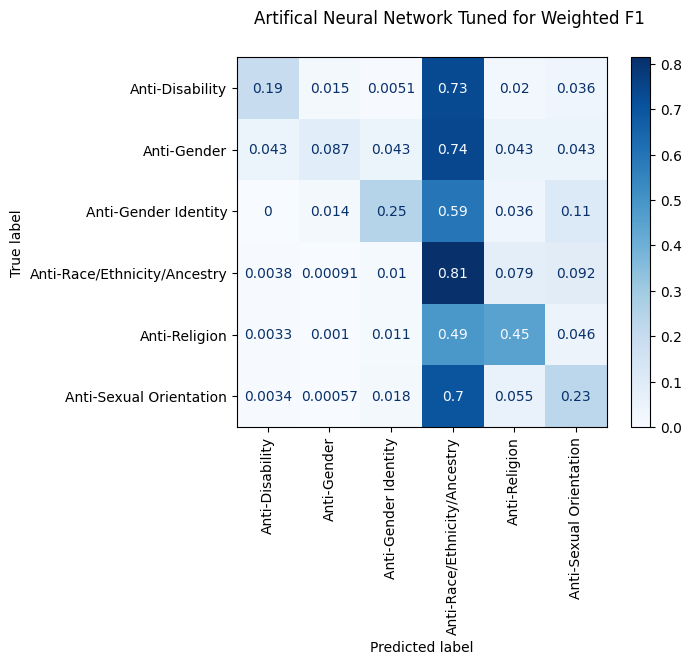

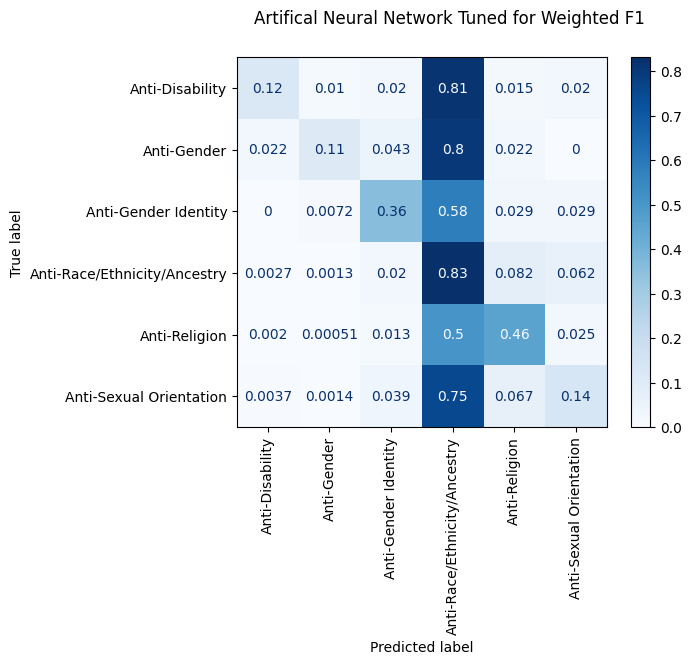

In [ ]:
sizes = [64]
rates = (x * 0.1 for x in [1, 5])

test_accuracies = []

for size in sizes:
  for rate in rates:
    checkpoint_no = f"ckpt_{checkpoint}_ANN"
    model_name = f"HC_ANN_2FC_F{size}_{size}_epoch_25_dropout_{rate}"
    checkpoint += 1

    input_shape = trainX.shape[1]

    n_batch_size = 32

    n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
    n_validation_steps = int(valX.shape[0] / n_batch_size)
    n_test_steps = int(testX.shape[0] / n_batch_size)

    n_epochs = 25

    num_classes = trainY.shape[1]

    model = models.Sequential()
    model.add(layers.Dense(size, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])

    # Prepare a directory to store all the checkpoints.
    checkpoint_dir = './'+ checkpoint_no
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name,
                                      monitor='val_loss', save_best_only=True, mode='auto')]

    history = model.fit(trainX,
                        trainY,
                        steps_per_epoch=n_steps_per_epoch,
                        epochs=n_epochs,
                        batch_size=n_batch_size,
                        validation_data=(valX, valY),
                        validation_steps=n_validation_steps,
                        callbacks=[keras_callbacks])

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    testY_fixed = np.argmax(testY, axis=1)

    print(classification_report(testY_fixed, y_pred, digits = 4))

    disp = ConfusionMatrixDisplay.from_predictions(testY_fixed, y_pred, normalize = 'true',
    cmap=plt.cm.Blues, display_labels=bias_groups_str, xticks_rotation = 'vertical')
    fig = disp.figure_
    fig.suptitle('Artifical Neural Network Tuned for Weighted F1')

    print('---------------------------------')

    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index + 1
    cols = list(hist_df.columns)
    cols = [cols[-1]] + cols[:-1]
    hist_df = hist_df[cols]
    hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
    hist_df.head()

    values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
    values_of_best_model

    class_assignment = dict(zip(y, encoded_Y))

    df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
    df_temp = df_temp.stack()
    df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
    df_temp.columns = ['Category', 'Allocated Number']

    df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

    pk.dump(encoder, open(checkpoint_no + '/' + 'encoder.pkl', 'wb'))

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    #plt.plot(epochs, acc, 'r', label='Training Accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    #plt.title('Training and Validation Accuracy')
    #plt.legend()

    #plt.figure()

    #plt.plot(epochs, loss, 'r', label='Training Loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()

    #plt.show()

    # Loading the automatically saved model
    model_reloaded = load_model(checkpoint_no + '/' + model_name)

    # Saving the best model in the correct path and format
    root_directory = os.getcwd()
    checkpoint_dir = os.path.join(root_directory, checkpoint_no)
    model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
    model_reloaded.save(model_name_temp)

    # Deletion of the automatically created folder under Model Checkpoint File.
    folder_name_temp = os.path.join(checkpoint_dir, model_name)
    shutil.rmtree(folder_name_temp, ignore_errors=True)

    best_model = load_model(model_name_temp)

    test_loss, test_acc = best_model.evaluate(testX,
                                              testY,
                                              steps=n_test_steps)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               26240     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 6)                 774       
                                                                 
Total params: 43,526
Trainable params: 43,526
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
21430/21431 [==========================

21431/21431 [==============================] - 61s 3ms/step - loss: 0.7314 - categorical_accuracy: 0.7134 - val_loss: 0.9436 - val_categorical_accuracy: 0.6299
Epoch 2/25
21421/21431 [============================>.] - ETA: 0s - loss: 0.6134 - categorical_accuracy: 0.7597

21431/21431 [==============================] - 61s 3ms/step - loss: 0.6134 - categorical_accuracy: 0.7597 - val_loss: 0.9339 - val_categorical_accuracy: 0.6385
Epoch 3/25
21431/21431 [==============================] - 60s 3ms/step - loss: 0.5807 - categorical_accuracy: 0.7724 - val_loss: 0.9886 - val_categorical_accuracy: 0.6092
Epoch 4/25
21431/21431 [==============================] - 60s 3ms/step - loss: 0.5620 - categorical_accuracy: 0.7791 - val_loss: 0.9465 - val_categorical_accuracy: 0.6312
Epoch 5/25
21422/21431 [============================>.] - ETA: 0s - loss: 0.5510 - categorical_accuracy: 0.7834

21431/21431 [==============================] - 60s 3ms/step - loss: 0.5510 - categorical_accuracy: 0.7834 - val_loss: 0.9299 - val_categorical_accuracy: 0.6425
Epoch 6/25
21415/21431 [============================>.] - ETA: 0s - loss: 0.5424 - categorical_accuracy: 0.7866

21431/21431 [==============================] - 62s 3ms/step - loss: 0.5425 - categorical_accuracy: 0.7866 - val_loss: 0.9294 - val_categorical_accuracy: 0.6421
Epoch 7/25
21431/21431 [==============================] - 60s 3ms/step - loss: 0.5355 - categorical_accuracy: 0.7890 - val_loss: 0.9348 - val_categorical_accuracy: 0.6389
Epoch 8/25
21425/21431 [============================>.] - ETA: 0s - loss: 0.5306 - categorical_accuracy: 0.7907

21431/21431 [==============================] - 61s 3ms/step - loss: 0.5306 - categorical_accuracy: 0.7907 - val_loss: 0.9214 - val_categorical_accuracy: 0.6469
Epoch 9/25
21423/21431 [============================>.] - ETA: 0s - loss: 0.5269 - categorical_accuracy: 0.7919

21431/21431 [==============================] - 62s 3ms/step - loss: 0.5269 - categorical_accuracy: 0.7919 - val_loss: 0.9187 - val_categorical_accuracy: 0.6454
Epoch 10/25
21428/21431 [============================>.] - ETA: 0s - loss: 0.5233 - categorical_accuracy: 0.7936

21431/21431 [==============================] - 64s 3ms/step - loss: 0.5233 - categorical_accuracy: 0.7936 - val_loss: 0.9071 - val_categorical_accuracy: 0.6570
Epoch 11/25
21431/21431 [==============================] - 61s 3ms/step - loss: 0.5204 - categorical_accuracy: 0.7943 - val_loss: 0.9494 - val_categorical_accuracy: 0.6364
Epoch 12/25
21431/21431 [==============================] - 59s 3ms/step - loss: 0.5179 - categorical_accuracy: 0.7953 - val_loss: 0.9351 - val_categorical_accuracy: 0.6405
Epoch 13/25
21431/21431 [==============================] - 62s 3ms/step - loss: 0.5155 - categorical_accuracy: 0.7965 - val_loss: 0.9197 - val_categorical_accuracy: 0.6505
Epoch 14/25
21431/21431 [==============================] - 61s 3ms/step - loss: 0.5136 - categorical_accuracy: 0.7965 - val_loss: 0.9400 - val_categorical_accuracy: 0.6427
Epoch 15/25
21431/21431 [==============================] - 60s 3ms/step - loss: 0.5112 - categorical_accuracy: 0.7974 - val_loss: 0.9442 - val_categoric

691/691 [==============================] - 1s 2ms/step - loss: 0.9000 - categorical_accuracy: 0.6552
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               26240     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 6)                 774       
                                                                 
Total params: 43,526
Trainable params: 43,526
Non-trainable params: 0
_______________

21431/21431 [==============================] - 67s 3ms/step - loss: 0.8986 - categorical_accuracy: 0.6489 - val_loss: 0.8977 - val_categorical_accuracy: 0.6531
Epoch 2/25
21431/21431 [==============================] - 63s 3ms/step - loss: 0.7898 - categorical_accuracy: 0.6950 - val_loss: 0.9274 - val_categorical_accuracy: 0.6495
Epoch 3/25
21431/21431 [==============================] - 62s 3ms/step - loss: 0.7652 - categorical_accuracy: 0.7049 - val_loss: 0.9347 - val_categorical_accuracy: 0.6430
Epoch 4/25
21431/21431 [==============================] - 62s 3ms/step - loss: 0.7501 - categorical_accuracy: 0.7106 - val_loss: 0.9019 - val_categorical_accuracy: 0.6592
Epoch 5/25
21431/21431 [==============================] - 61s 3ms/step - loss: 0.7403 - categorical_accuracy: 0.7152 - val_loss: 0.9293 - val_categorical_accuracy: 0.6411
Epoch 6/25
21431/21431 [==============================] - 62s 3ms/step - loss: 0.7321 - categorical_accuracy: 0.7176 - val_loss: 0.9341 - val_categorical_ac

21431/21431 [==============================] - 61s 3ms/step - loss: 0.7027 - categorical_accuracy: 0.7300 - val_loss: 0.8923 - val_categorical_accuracy: 0.6636
Epoch 19/25
21431/21431 [==============================] - 61s 3ms/step - loss: 0.7016 - categorical_accuracy: 0.7301 - val_loss: 0.9338 - val_categorical_accuracy: 0.6376
Epoch 20/25
21431/21431 [==============================] - 62s 3ms/step - loss: 0.7001 - categorical_accuracy: 0.7307 - val_loss: 0.9317 - val_categorical_accuracy: 0.6466
Epoch 21/25
21431/21431 [==============================] - 62s 3ms/step - loss: 0.6993 - categorical_accuracy: 0.7308 - val_loss: 0.9196 - val_categorical_accuracy: 0.6515
Epoch 22/25
21431/21431 [==============================] - 61s 3ms/step - loss: 0.6987 - categorical_accuracy: 0.7319 - val_loss: 0.9015 - val_categorical_accuracy: 0.6615
Epoch 23/25
21431/21431 [==============================] - 58s 3ms/step - loss: 0.6973 - categorical_accuracy: 0.7320 - val_loss: 0.9069 - val_categoric

691/691 [==============================] - 2s 2ms/step - loss: 0.8964 - categorical_accuracy: 0.6586


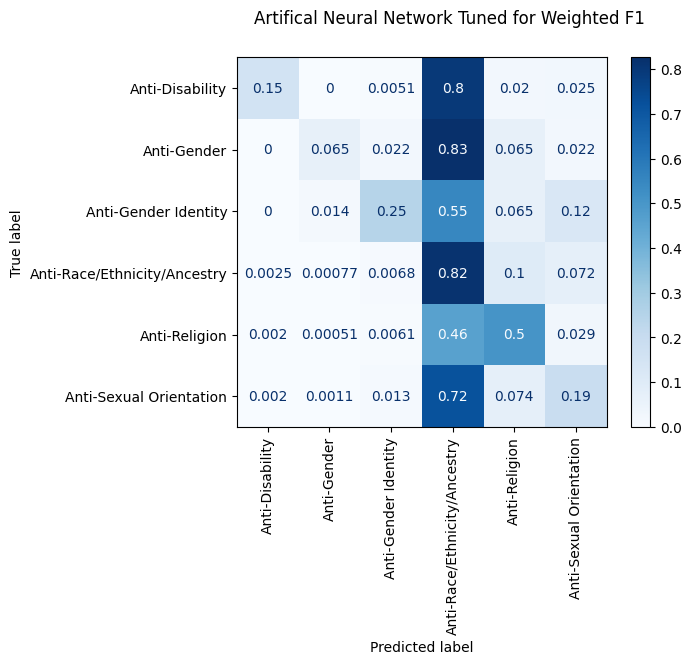

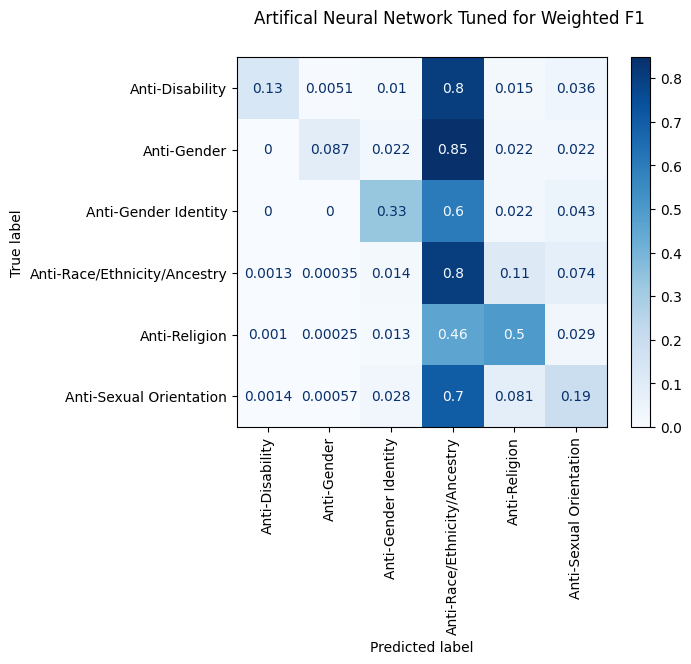

In [ ]:
sizes = [128]
rates = (x * 0.1 for x in [1, 5])

test_accuracies = []

for size in sizes:
  for rate in rates:
    checkpoint_no = f"ckpt_{checkpoint}_ANN"
    model_name = f"HC_ANN_2FC_F{size}_{size}_epoch_25_dropout_{rate}"
    checkpoint += 1

    input_shape = trainX.shape[1]

    n_batch_size = 32

    n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
    n_validation_steps = int(valX.shape[0] / n_batch_size)
    n_test_steps = int(testX.shape[0] / n_batch_size)

    n_epochs = 25

    num_classes = trainY.shape[1]

    model = models.Sequential()
    model.add(layers.Dense(size, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])

    # Prepare a directory to store all the checkpoints.
    checkpoint_dir = './'+ checkpoint_no
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name,
                                      monitor='val_loss', save_best_only=True, mode='auto')]

    history = model.fit(trainX,
                        trainY,
                        steps_per_epoch=n_steps_per_epoch,
                        epochs=n_epochs,
                        batch_size=n_batch_size,
                        validation_data=(valX, valY),
                        validation_steps=n_validation_steps,
                        callbacks=[keras_callbacks])

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    testY_fixed = np.argmax(testY, axis=1)

    print(classification_report(testY_fixed, y_pred, digits = 4))

    disp = ConfusionMatrixDisplay.from_predictions(testY_fixed, y_pred, normalize = 'true',
    cmap=plt.cm.Blues, display_labels=bias_groups_str, xticks_rotation = 'vertical')
    fig = disp.figure_
    fig.suptitle('Artifical Neural Network Tuned for Weighted F1')

    print('---------------------------------')

    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index + 1
    cols = list(hist_df.columns)
    cols = [cols[-1]] + cols[:-1]
    hist_df = hist_df[cols]
    hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
    hist_df.head()

    values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
    values_of_best_model

    class_assignment = dict(zip(y, encoded_Y))

    df_temp = pd.DataFrame([class_assignment], columns=class_assignment.keys())
    df_temp = df_temp.stack()
    df_temp = pd.DataFrame(df_temp).reset_index().drop(['level_0'], axis=1)
    df_temp.columns = ['Category', 'Allocated Number']

    df_temp.to_csv(checkpoint_no + '/' + 'class_assignment_df_' + model_name + '.csv')

    pk.dump(encoder, open(checkpoint_no + '/' + 'encoder.pkl', 'wb'))

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    #plt.plot(epochs, acc, 'r', label='Training Accuracy')
    #plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    #plt.title('Training and Validation Accuracy')
    #plt.legend()

    #plt.figure()

    #plt.plot(epochs, loss, 'r', label='Training Loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()

    #plt.show()

    # Loading the automatically saved model
    model_reloaded = load_model(checkpoint_no + '/' + model_name)

    # Saving the best model in the correct path and format
    root_directory = os.getcwd()
    checkpoint_dir = os.path.join(root_directory, checkpoint_no)
    model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
    model_reloaded.save(model_name_temp)

    # Deletion of the automatically created folder under Model Checkpoint File.
    folder_name_temp = os.path.join(checkpoint_dir, model_name)
    shutil.rmtree(folder_name_temp, ignore_errors=True)

    best_model = load_model(model_name_temp)

    test_loss, test_acc = best_model.evaluate(testX,
                                              testY,
                                              steps=n_test_steps)